In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import os, sys
from glob import glob
from os.path import join, isfile
import numpy as np
import pandas as pd

import time
from datetime import datetime
from copy import deepcopy

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, get_scorer, make_scorer, confusion_matrix
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ParameterGrid, StratifiedKFold

from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from joblib import Parallel, delayed, dump, load

# Local imports
from MLpipeline import *
from confounds import *

In [3]:
# Define settings for the experiment 
DATA_DIR = "/ritter/share/data/IMAGEN"

## Permutation tests
# Total number of permutation tests to run. Set to 0 to not perform any permutations. 
N_PERMUTATIONS = 1000
N_JOBS = 30 # parallel jobs
PARALLELIZE = False # within each MLPipeline trial, do you want to parallelize the permutation test runs too?
# if set to true it will run 1 trial with no parallel jobs and enables debug msgs
DEBUG = False
    
if DEBUG:
    if N_PERMUTATIONS > 2:
        N_PERMUTATIONS = 2
    N_JOBS = 1 
    PARALLELIZE = False

In [4]:
dirs = ['newlbls-bl-*', 'newlbls-fu2-*', 'newlbls-fu3-*']

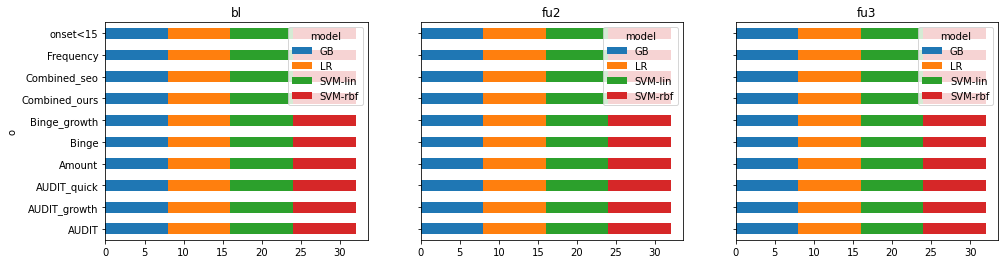

,o,model,trial,test_score,valid_score,train_score,roc_auc,model_SVM-rbf__C,model_SVM-rbf__gamma,model_SVM-lin__C,model_LR__C,model_GB__learning_rate,path,path_type
0,Binge,SVM-rbf,3,0.738095,0.681725,0.899097,0.850529,1000.0,scale,NaN,NaN,NaN,results/newlbls-bl-espad-fu3-19a-binge-n620/20...,bl
1,Binge,SVM-rbf,2,0.759921,0.684937,0.902405,0.829696,1.0,auto,NaN,NaN,NaN,results/newlbls-bl-espad-fu3-19a-binge-n620/20...,bl
2,Binge,GB,0,0.791667,0.676688,0.977842,0.823413,NaN,NaN,NaN,NaN,0.25,results/newlbls-bl-espad-fu3-19a-binge-n620/20...,bl
3,Binge,SVM-rbf,7,0.760163,0.700548,0.889962,0.805894,1.0,scale,NaN,NaN,NaN,results/newlbls-bl-espad-fu3-19a-binge-n620/20...,bl
4,Binge,SVM-rbf,0,0.688492,0.675742,0.905163,0.800926,1000.0,scale,NaN,NaN,NaN,results/newlbls-bl-espad-fu3-19a-binge-n620/20...,bl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,onset<15,GB,7,0.457341,0.509410,0.956143,0.410714,NaN,NaN,NaN,NaN,0.05,results/newlbls-fu3-espad-fu3-29d-onset-15-n69...,fu3
956,onset<15,SVM-rbf,5,0.468254,0.519639,0.890126,0.409392,1.0,scale,NaN,NaN,NaN,results/newlbls-fu3-espad-fu3-29d-onset-15-n69...,fu3
957,Frequency,SVM-lin,4,0.409035,0.505567,0.912027,0.394383,NaN,NaN,0.001,NaN,NaN,results/newlbls-fu3-espad-fu3-8c-frequency-n71...,fu3
958,Frequency,SVM-lin,3,0.420330,0.532849,0.913205,0.378510,NaN,NaN,0.001,NaN,NaN,results/newlbls-fu3-espad-fu3-8c-frequency-n71...,fu3


In [5]:

sort_by = "roc_auc"  #"roc_auc" #
best_results = pd.DataFrame()
fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(16,4))

for i,each_dir in enumerate(dirs):
    
    results = pd.DataFrame()
    for f in glob(f"results/{each_dir}/*/run.csv"):
        run = pd.read_csv(f)
        run = run[~(run.o_is_conf) & ~(run.i_is_conf) & (run.technique=='cb')]
        run["path"] = f.replace("/run.csv", "")
        results = pd.concat([results, run])

    # results = results.sort_values("test_score", ascending=False)
    results = results.sort_values(sort_by, ascending=False)#.iloc[:10]
    hyper_cols = results.filter(like="model_").columns
    results = results.filter(items=["o", "model", "trial", "test_score", "valid_score", "train_score", "roc_auc", *hyper_cols, "path"])
    results["path_type"]= each_dir.replace("new", "").replace("lbls-", "").replace("*", "").replace("-", "")
    results[["o", "model"]].value_counts().unstack().plot.barh(stacked=True, title=results["path_type"].iloc[0], ax=axes[i])
    best_results = pd.concat([best_results, results])

plt.show()

best_results = best_results.reset_index(drop=True)
best_results#.sort_values(["path_type", sort_by], ascending=False)

<AxesSubplot:ylabel='o'>

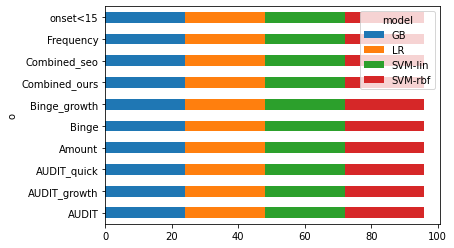

In [6]:
best_results[["o", "model"]].value_counts().unstack().plot.barh(stacked=True)

In [ ]:
from slugify import slugify

best_results["holdout_score"] = np.nan
best_results["holdout_roc_auc"] = np.nan

print("========================================")
start_time = datetime.now()
print("time: ", start_time)

for k, row in best_results.iterrows():
    
    tp = row.path_type
    print(f"Testing ML model from: {row.path}")
    
    # load the trained model
    model = load(f"{row.path}/{row.model}_{row.trial}.model")
    
    # load the training data    
    h5_path = "/ritter/share/data/IMAGEN/h5files/{}.h5".format(row.path.split('/')[-2])
    data = h5py.File(h5_path, "r")
    X = data['X'][()]
    y_name = data.attrs['labels'][0]
    y = data[y_name][()]    
    confs = {}
    for c in data.attrs['confs']:
        confs[c] = np.array(data[c]) 
        
    # load the holdout data 
    y_name_h5 = slugify(y_name)
    if y_name_h5 == "audit": y_name_h5+="-total"
        
    test_h5_path = sorted(glob("/ritter/share/data/IMAGEN/h5files/newholdout-{}*{}*.h5".format(tp, y_name_h5)))
    assert ((len(test_h5_path)==1) or ("binge" in y_name_h5)), "for label {}, multiple test set files found: {}".format(slugify(y_name), test_h5_path)
    h5_path_holdout = test_h5_path[0]
    test_data = h5py.File(h5_path_holdout, "r")
    
    X_test = test_data['X'][()]
    y_test = test_data[y_name][()]    
#     print("n(train_data) = {}\t n(test_data)={} \t n(features) = {}".format(len(X), len(X_test), X.shape[-1]))
        
    # prepare confound-correction params
    confs_grouped = np.array([])
    for c, v in confs.items():               
        if confs_grouped.size == 0:
            confs_grouped = v
        else:
            confs_grouped = 100*confs_grouped + v
            
    conf_corr_params={"conf_corr_cb__groups": confs_grouped}
    # retrain on entire data
    model = model.fit(X, y, **conf_corr_params)
    
    test_score = make_scorer(balanced_accuracy_score)(model, X_test, y_test)  
    # Calculate AUC if label is binary       
    roc_auc = get_scorer("roc_auc")(model, X_test, y_test)  
    
    
    best_results.loc[k, "holdout_score"] = test_score    
    best_results.loc[k, "holdout_roc_auc"] = roc_auc  
    print("training accuracy: {:0.2f}% \t holdout accuracy: {:0.2f}% \t holdout AUC ROC: {:0.2f}%".format(
         make_scorer(balanced_accuracy_score)(model, X, y)*100, test_score*100, roc_auc*100))

runtime=str(datetime.now()-start_time).split(".")[0]
print("TOTAL RUNTIME: {} secs".format(runtime))

time:  2021-06-18 12:17:50.861877
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 98.50% 	 holdout accuracy: 71.54% 	 holdout AUC ROC: 79.90%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 96.41% 	 holdout accuracy: 70.38% 	 holdout AUC ROC: 78.40%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.75% 	 holdout accuracy: 71.86% 	 holdout AUC ROC: 78.60%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 95.81% 	 holdout accuracy: 74.62% 	 holdout AUC ROC: 78.87%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 98.20% 	 holdout accuracy: 72.39% 	 holdout AUC ROC: 81.12%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.35% 	 holdout accuracy: 71.54% 	 holdout AUC ROC: 82.38%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.98% 	 holdout accuracy: 69.85% 	 holdout AUC ROC: 80.80%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.40% 	 holdout accuracy: 54.21% 	 holdout AUC ROC: 58.14%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.70% 	 holdout accuracy: 76.19% 	 holdout AUC ROC: 83.41%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 97.50% 	 holdout accuracy: 55.27% 	 holdout AUC ROC: 58.04%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.82% 	 holdout accuracy: 61.76% 	 holdout AUC ROC: 62.46%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 96.16% 	 holdout accuracy: 72.39% 	 holdout AUC ROC: 78.99%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.65% 	 holdout accuracy: 49.88% 	 holdout AUC ROC: 48.05%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.15% 	 holdout accuracy: 74.40% 	 holdout AUC ROC: 81.16%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.40% 	 holdout accuracy: 48.99% 	 holdout AUC ROC: 48.32%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 98.85% 	 holdout accuracy: 73.24% 	 holdout AUC ROC: 81.75%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 95.65% 	 holdout accuracy: 62.38% 	 holdout AUC ROC: 66.87%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 97.58% 	 holdout accuracy: 57.86% 	 holdout AUC ROC: 64.28%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 98.65% 	 holdout accuracy: 58.53% 	 holdout AUC ROC: 64.55%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.99% 	 holdout accuracy: 56.82% 	 holdout AUC ROC: 56.23%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 93.08% 	 holdout accuracy: 62.79% 	 holdout AUC ROC: 72.20%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.75% 	 holdout accuracy: 54.36% 	 holdout AUC ROC: 56.77%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 79.65% 	 holdout accuracy: 58.92% 	 holdout AUC ROC: 58.51%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029
training accuracy: 98.14% 	 holdout accuracy: 52.27% 	 holdout AUC ROC: 63.75%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 77.28% 	 holdout accuracy: 61.85% 	 holdout AUC ROC: 62.20%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 95.71% 	 holdout accuracy: 63.22% 	 holdout AUC ROC: 68.09%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 98.49% 	 holdout accuracy: 55.13% 	 holdout AUC ROC: 63.11%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-bin

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.20% 	 holdout accuracy: 67.57% 	 holdout AUC ROC: 72.76%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.97% 	 holdout accuracy: 64.31% 	 holdout AUC ROC: 68.34%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.73% 	 holdout accuracy: 74.50% 	 holdout AUC ROC: 82.07%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 96.36% 	 holdout accuracy: 65.11% 	 holdout AUC ROC: 67.53%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029
training accuracy: 98.01% 	 holdout accuracy: 51.01% 	 holdout AUC ROC: 53.98%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 94.61% 	 holdout accuracy: 62.99% 	 holdout AUC ROC: 73.15%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 96.29% 	 holdout accuracy: 65.29% 	 holdout AUC ROC: 67.14%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 94.16% 	 holdout accuracy: 55.26% 	 holdout AUC ROC: 63.71%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n62

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.01% 	 holdout accuracy: 58.58% 	 holdout AUC ROC: 66.91%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 96.83% 	 holdout accuracy: 62.95% 	 holdout AUC ROC: 66.29%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 99.05% 	 holdout accuracy: 65.83% 	 holdout AUC ROC: 73.83%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 94.96% 	 holdout accuracy: 70.38% 	 holdout AUC ROC: 78.56%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.19% 	 holdout accuracy: 65.13% 	 holdout AUC ROC: 71.26%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029
training accuracy: 94.88% 	 holdout accuracy: 53.03% 	 holdout AUC ROC: 63.58%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.88% 	 holdout accuracy: 73.87% 	 holdout AUC ROC: 81.51%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 96.22% 	 holdout accuracy: 60.61% 	 holdout AUC ROC: 67.19%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.20% 	 holdout accuracy: 64.88% 	 holdout AUC ROC: 70.64%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.62% 	 holdout accuracy: 58.53% 	 holdout AUC ROC: 68.48%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029
training accuracy: 97.47% 	 holdout accuracy: 52.61% 	 holdout AUC ROC: 56.23%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 96.56% 	 holdout accuracy: 55.35% 	 holdout AUC ROC: 54.68%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.36% 	 holdout accuracy: 66.38% 	 holdout AUC ROC: 70.98%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.62% 	 holdout accuracy: 63.32% 	 holdout AUC ROC: 73.73%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029
training accuracy: 97.20% 	 holdout accuracy: 50.34% 	 holdout AUC ROC: 52.41%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 76.53% 	 holdout accuracy: 52.95% 	 holdout AUC ROC: 57.33%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 98.50% 	 holdout accuracy: 71.54% 	 holdout AUC ROC: 75.84%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029
training accuracy: 96.65% 	 holdout accuracy: 53.79% 	 holdout AUC ROC: 66.11%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 80.71% 	 holdout accuracy: 62.75% 	 holdout AUC ROC: 66.54%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029
training accu

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.59% 	 holdout accuracy: 53.94% 	 holdout AUC ROC: 48.84%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 98.12% 	 holdout accuracy: 56.11% 	 holdout AUC ROC: 62.81%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 94.46% 	 holdout accuracy: 49.51% 	 holdout AUC ROC: 51.69%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 78.06% 	 holdout accuracy: 69.53% 	 holdout AUC ROC: 71.50%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 96.43% 	 holdout accuracy: 61.12% 	 holdout AUC ROC: 67.23%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 95.60% 	 holdout accuracy: 50.61% 	 holdout AUC ROC: 47.82%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.18% 	 holdout accuracy: 52.80% 	 holdout AUC ROC: 58.96%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 95.72% 	 holdout accuracy: 66.16% 	 holdout AUC ROC: 69.28%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 94.96% 	 holdout accuracy: 66.69% 	 holdout AUC ROC: 73.07%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 78.03% 	 holdout accuracy: 60.24% 	 holdout AUC ROC: 64.31%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.45% 	 holdout accuracy: 50.51% 	 holdout AUC ROC: 62.35%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.03% 	 holdout accuracy: 57.03% 	 holdout AUC ROC: 63.20%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 97.62% 	 holdout accuracy: 53.94% 	 holdout AUC ROC: 58.79%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.12% 	 holdout accuracy: 52.40% 	 holdout AUC ROC: 52.70%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 94.97% 	 holdout accuracy: 62.75% 	 holdout AUC ROC: 71.79%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 94.93% 	 holdout accuracy: 57.78% 	 holdout AUC ROC: 63.77%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 76.44% 	 holdout accuracy: 53.67% 	 holdout AUC ROC: 62.08%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 97.83% 	 holdout accuracy: 70.38% 	 holdout AUC ROC: 72.21%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 95.46% 	 holdout accuracy: 60.96% 	 holdout AUC ROC: 70.74%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.66% 	 holdout accuracy: 61.08% 	 holdout AUC ROC: 59.82%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 93.52% 	 holdout accuracy: 70.46% 	 holdout AUC ROC: 75.42%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 96.56% 	 holdout accuracy: 66.20% 	 holdout AUC ROC: 69.88%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 91.70% 	 holdout accuracy: 59.38% 	 holdout AUC ROC: 67.72%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 95.00% 	 holdout accuracy: 58.42% 	 holdout AUC ROC: 65.88%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.33% 	 holdout accuracy: 49.72% 	 holdout AUC ROC: 47.86%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.38% 	 holdout accuracy: 72.49% 	 holdout AUC ROC: 78.48%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.35% 	 holdout accuracy: 48.13% 	 holdout AUC ROC: 53.24%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 93.80% 	 holdout accuracy: 57.23% 	 holdout AUC ROC: 65.31%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 98.04% 	 holdout accuracy: 65.29% 	 holdout AUC ROC: 66.12%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.02% 	 holdout accuracy: 53.33% 	 holdout AUC ROC: 61.21%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 94.73% 	 holdout accuracy: 59.31% 	 holdout AUC ROC: 67.72%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.55% 	 holdout accuracy: 68.62% 	 holdout AUC ROC: 72.72%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 98.05% 	 holdout accuracy: 64.35% 	 holdout AUC ROC: 72.88%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029
training accuracy: 94.12% 	 holdout accuracy: 51.60% 	 holdout AUC ROC: 68.57%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 74.83% 	 holdout accuracy: 56.95% 	 holdout AUC ROC: 56.53%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.39% 	 holdout accuracy: 69.66% 	 holdout AUC ROC: 77.86%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.57% 	 holdout accuracy: 61.38% 	 holdout AUC ROC: 63.48%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 76.44% 	 holdout accuracy: 62.29% 	 holdout AUC ROC: 62.66%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.08% 	 holdout accuracy: 62.25% 	 holdout AUC ROC: 65.38%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.25% 	 holdout accuracy: 54.92% 	 holdout AUC ROC: 56.53%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 75.81% 	 holdout accuracy: 57.93% 	 holdout AUC ROC: 58.19%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.00% 	 holdout accuracy: 65.92% 	 holdout AUC ROC: 74.09%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 91.94% 	 holdout accuracy: 66.98% 	 holdout AUC ROC: 70.81%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 97.03% 	 holdout accuracy: 55.13% 	 holdout AUC ROC: 59.55%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 94.88% 	 holdout accuracy: 63.34% 	 holdout AUC ROC: 67.92%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 98.03% 	 holdout accuracy: 69.22% 	 holdout AUC ROC: 81.08%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.38% 	 holdout accuracy: 66.48% 	 holdout AUC ROC: 70.58%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 92.87% 	 holdout accuracy: 48.76% 	 holdout AUC ROC: 55.88%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 92.83% 	 holdout accuracy: 48.43% 	 holdout AUC ROC: 59.86%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 76.21% 	 holdout accuracy: 60.49% 	 holdout AUC ROC: 60.61%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 78.56% 	 holdout accuracy: 56.49% 	 holdout AUC ROC: 59.71%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.88% 	 holdout accuracy: 69.14% 	 holdout AUC ROC: 73.07%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 91.07% 	 holdout accuracy: 60.18% 	 holdout AUC ROC: 65.85%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 95.69% 	 holdout accuracy: 66.73% 	 holdout AUC ROC: 71.07%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.11% 	 holdout accuracy: 65.35% 	 holdout AUC ROC: 70.75%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.58% 	 holdout accuracy: 61.46% 	 holdout AUC ROC: 68.68%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.92% 	 holdout accuracy: 45.26% 	 holdout AUC ROC: 46.24%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.95% 	 holdout accuracy: 56.45% 	 holdout AUC ROC: 62.41%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 96.01% 	 holdout accuracy: 53.01% 	 holdout AUC ROC: 52.06%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 73.97% 	 holdout accuracy: 51.56% 	 holdout AUC ROC: 50.67%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029
training accuracy: 96.86% 	 holdout accuracy: 53.45% 	 holdout AUC ROC: 64.53%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 95.82% 	 holdout accuracy: 63.50% 	 holdout AUC ROC: 69.81%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 98.35% 	 holdout accuracy: 53.45% 	 holdout AUC ROC: 57.38%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 94.15% 	 holdout accuracy: 57.93% 	 holdout AUC ROC: 65.41%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.29% 	 holdout accuracy: 60.74% 	 holdout AUC ROC: 66.29%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.92% 	 holdout accuracy: 53.62% 	 holdout AUC ROC: 61.18%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 79.14% 	 holdout accuracy: 67.29% 	 holdout AUC ROC: 65.08%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.90% 	 holdout accuracy: 53.73% 	 holdout AUC ROC: 57.14%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029
training accuracy: 96.97% 	 holdout accuracy: 50.25% 	 holdout AUC ROC: 55.33%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 81.65% 	 holdout accuracy: 62.97% 	 holdout AUC ROC: 67.01%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 95.57% 	 holdout accuracy: 60.11% 	 holdout AUC ROC: 67.59%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 96.22% 	 holdout accuracy: 65.92% 	 holdout AUC ROC: 69.53%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029
training accuracy: 98.35% 	 holdout accuracy: 54.46% 	 holdout AUC ROC: 63.97%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.53% 	 holdout accuracy: 64.51% 	 holdout AUC ROC: 68.36%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.57% 	 holdout accuracy: 70.11% 	 holdout AUC ROC: 75.12%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 95.96% 	 holdout accuracy: 57.38% 	 holdout AUC ROC: 59.04%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 74.92% 	 holdout accuracy: 51.45% 	 holdout AUC ROC: 50.67%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.73% 	 holdout accuracy: 63.22% 	 holdout AUC ROC: 71.28%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.77% 	 holdout accuracy: 57.33% 	 holdout AUC ROC: 60.90%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 95.61% 	 holdout accuracy: 62.75% 	 holdout AUC ROC: 71.01%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 94.24% 	 holdout accuracy: 65.54% 	 holdout AUC ROC: 71.43%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.45% 	 holdout accuracy: 59.60% 	 holdout AUC ROC: 61.74%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 77.82% 	 holdout accuracy: 60.11% 	 holdout AUC ROC: 63.95%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 95.45% 	 holdout accuracy: 48.99% 	 holdout AUC ROC: 62.10%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 93.72% 	 holdout accuracy: 63.73% 	 holdout AUC ROC: 65.40%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 94.78% 	 holdout accuracy: 66.96% 	 holdout AUC ROC: 73.47%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 95.49% 	 holdout accuracy: 67.25% 	 holdout AUC ROC: 70.20%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 68.38% 	 holdout accuracy: 57.79% 	 holdout AUC ROC: 54.00%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.33% 	 holdout accuracy: 55.33% 	 holdout AUC ROC: 54.33%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 95.71% 	 holdout accuracy: 63.84% 	 holdout AUC ROC: 70.74%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 77.27% 	 holdout accuracy: 60.73% 	 holdout AUC ROC: 59.95%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 95.13% 	 holdout accuracy: 48.76% 	 holdout AUC ROC: 49.69%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 75.17% 	 holdout accuracy: 56.32% 	 holdout AUC ROC: 58.85%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.51% 	 holdout accuracy: 56.06% 	 holdout AUC ROC: 61.28%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 96.53% 	 holdout accuracy: 58.58% 	 holdout AUC ROC: 61.74%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 74.66% 	 holdout accuracy: 54.78% 	 holdout AUC ROC: 56.74%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029
training accuracy: 96.63% 	 holdout accuracy: 52.19% 	 holdout AUC ROC: 55.84%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.47% 	 holdout accuracy: 58.41% 	 holdout AUC ROC: 58.72%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 95.99% 	 holdout accuracy: 53.42% 	 holdout AUC ROC: 55.63%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 97.33% 	 holdout accuracy: 53.09% 	 holdout AUC ROC: 56.53%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 98.18% 	 holdout accuracy: 72.07% 	 holdout AUC ROC: 76.67%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 91.85% 	 holdout accuracy: 60.29% 	 holdout AUC ROC: 65.74%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.27% 	 holdout accuracy: 57.57% 	 holdout AUC ROC: 60.81%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 95.99% 	 holdout accuracy: 52.64% 	 holdout AUC ROC: 66.67%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 76.98% 	 holdout accuracy: 61.08% 	 holdout AUC ROC: 64.31%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.24% 	 holdout accuracy: 59.19% 	 holdout AUC ROC: 62.87%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 95.54% 	 holdout accuracy: 59.44% 	 holdout AUC ROC: 63.75%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 96.27% 	 holdout accuracy: 55.19% 	 holdout AUC ROC: 59.12%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 99.00% 	 holdout accuracy: 68.68% 	 holdout AUC ROC: 72.76%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 76.01% 	 holdout accuracy: 50.49% 	 holdout AUC ROC: 58.51%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.34% 	 holdout accuracy: 55.56% 	 holdout AUC ROC: 56.12%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 96.76% 	 holdout accuracy: 57.73% 	 holdout AUC ROC: 62.67%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 94.07% 	 holdout accuracy: 65.24% 	 holdout AUC ROC: 75.47%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 78.02% 	 holdout accuracy: 53.17% 	 holdout AUC ROC: 58.84%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.62% 	 holdout accuracy: 54.01% 	 holdout AUC ROC: 54.93%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 76.14% 	 holdout accuracy: 50.26% 	 holdout AUC ROC: 53.51%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 78.54% 	 holdout accuracy: 57.85% 	 holdout AUC ROC: 60.17%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 78.61% 	 holdout accuracy: 58.10% 	 holdout AUC ROC: 59.38%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 74.29% 	 holdout accuracy: 57.57% 	 holdout AUC ROC: 61.76%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 73.36% 	 holdout accuracy: 61.62% 	 holdout AUC ROC: 62.59%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 98.96% 	 holdout accuracy: 51.15% 	 holdout AUC ROC: 54.63%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 96.95% 	 holdout accuracy: 63.25% 	 holdout AUC ROC: 60.73%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 96.89% 	 holdout accuracy: 64.51% 	 holdout AUC ROC: 65.89%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 77.69% 	 holdout accuracy: 51.05% 	 holdout AUC ROC: 55.86%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 96.24% 	 holdout accuracy: 60.07% 	 holdout AUC ROC: 57.90%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 99.35% 	 holdout accuracy: 71.23% 	 holdout AUC ROC: 74.77%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.97% 	 holdout accuracy: 58.26% 	 holdout AUC ROC: 59.38%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 99.05% 	 holdout accuracy: 74.18% 	 holdout AUC ROC: 78.44%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 78.76% 	 holdout accuracy: 69.22% 	 holdout AUC ROC: 67.91%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 95.30% 	 holdout accuracy: 48.76% 	 holdout AUC ROC: 47.62%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.53% 	 holdout accuracy: 54.21% 	 holdout AUC ROC: 57.24%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 76.68% 	 holdout accuracy: 55.61% 	 holdout AUC ROC: 53.61%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 98.62% 	 holdout accuracy: 51.49% 	 holdout AUC ROC: 56.08%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 98.01% 	 holdout accuracy: 47.64% 	 holdout AUC ROC: 52.19%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.89% 	 holdout accuracy: 50.67% 	 holdout AUC ROC: 54.26%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 96.01% 	 holdout accuracy: 54.23% 	 holdout AUC ROC: 52.75%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 78.06% 	 holdout accuracy: 52.30% 	 holdout AUC ROC: 58.35%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 97.01% 	 holdout accuracy: 59.71% 	 holdout AUC ROC: 60.73%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029
training accuracy: 97.43% 	 holdout accuracy: 48.82% 	 holdout AUC ROC: 56.73%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 96.35% 	 holdout accuracy: 56.05% 	 holdout AUC ROC: 59.82%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quic

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.12% 	 holdout accuracy: 63.74% 	 holdout AUC ROC: 71.28%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 76.10% 	 holdout accuracy: 61.51% 	 holdout AUC ROC: 59.79%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.99% 	 holdout accuracy: 50.56% 	 holdout AUC ROC: 61.35%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 97.85% 	 holdout accuracy: 56.88% 	 holdout AUC ROC: 63.23%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 77.07% 	 holdout accuracy: 55.85% 	 holdout AUC ROC: 54.44%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 97.29% 	 holdout accuracy: 55.92% 	 holdout AUC ROC: 62.41%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 95.04% 	 holdout accuracy: 50.61% 	 holdout AUC ROC: 52.50%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031
training accuracy: 76.93% 	 holdout accuracy: 63.78% 	 holdout AUC ROC: 66.27%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-a

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 98.11% 	 holdout accuracy: 60.47% 	 holdout AUC ROC: 61.47%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 82.08% 	 holdout accuracy: 64.98% 	 holdout AUC ROC: 66.65%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 95.99% 	 holdout accuracy: 53.42% 	 holdout AUC ROC: 54.06%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 97.90% 	 holdout accuracy: 71.23% 	 holdout AUC ROC: 77.30%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 94.07% 	 holdout accuracy: 69.55% 	 holdout AUC ROC: 82.20%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 96.06% 	 holdout accuracy: 61.46% 	 holdout AUC ROC: 52.67%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.07% 	 holdout accuracy: 58.92% 	 holdout AUC ROC: 59.77%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.30% 	 holdout accuracy: 58.23% 	 holdout AUC ROC: 56.51%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 94.33% 	 holdout accuracy: 56.63% 	 holdout AUC ROC: 53.72%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 95.04% 	 holdout accuracy: 65.35% 	 holdout AUC ROC: 67.91%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 95.67% 	 holdout accuracy: 58.26% 	 holdout AUC ROC: 61.43%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 98.39% 	 holdout accuracy: 50.30% 	 holdout AUC ROC: 56.11%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 96.89% 	 holdout accuracy: 51.49% 	 holdout AUC ROC: 52.95%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 95.49% 	 holdout accuracy: 48.96% 	 holdout AUC ROC: 45.71%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 97.36% 	 holdout accuracy: 58.26% 	 holdout AUC ROC: 61.03%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.75% 	 holdout accuracy: 66.38% 	 holdout AUC ROC: 68.08%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.69% 	 holdout accuracy: 57.22% 	 holdout AUC ROC: 55.48%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.45% 	 holdout accuracy: 49.51% 	 holdout AUC ROC: 50.39%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.99% 	 holdout accuracy: 55.39% 	 holdout AUC ROC: 57.97%
Testing ML model from: results/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781/20210618-1031


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.80% 	 holdout accuracy: 57.29% 	 holdout AUC ROC: 62.03%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.52% 	 holdout accuracy: 51.46% 	 holdout AUC ROC: 64.72%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.99% 	 holdout accuracy: 56.14% 	 holdout AUC ROC: 54.32%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 95.83% 	 holdout accuracy: 52.58% 	 holdout AUC ROC: 53.85%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 94.55% 	 holdout accuracy: 61.15% 	 holdout AUC ROC: 63.90%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.52% 	 holdout accuracy: 50.22% 	 holdout AUC ROC: 61.35%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 77.05% 	 holdout accuracy: 54.09% 	 holdout AUC ROC: 61.39%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 95.64% 	 holdout accuracy: 56.29% 	 holdout AUC ROC: 51.89%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 75.65% 	 holdout accuracy: 49.08% 	 holdout AUC ROC: 53.45%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.83% 	 holdout accuracy: 65.03% 	 holdout AUC ROC: 68.48%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 97.59% 	 holdout accuracy: 54.66% 	 holdout AUC ROC: 55.89%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038
training accuracy: 97.56% 	 holdout accuracy: 55.69% 	 holdout AUC ROC: 59.28%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 94.28% 	 holdout accuracy: 69.08% 	 holdout AUC ROC: 72.82%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.40% 	 holdout accuracy: 57.73% 	 holdout AUC ROC: 58.15%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 95.44% 	 holdout accuracy: 61.18% 	 holdout AUC ROC: 71.50%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 94.39% 	 holdout accuracy: 58.12% 	 holdout AUC ROC: 57.45%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 95.80% 	 holdout accuracy: 63.86% 	 holdout AUC ROC: 65.71%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029
training accuracy: 97.80% 	 holdout accuracy: 48.06% 	 holdout AUC ROC: 52.97%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 77.42% 	 holdout accuracy: 61.86% 	 holdout AUC ROC: 62.68%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 97.06% 	 holdout accuracy: 51.12% 	 holdout AUC ROC: 59.82%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 98.83% 	 holdout accuracy: 53.28% 	 holdout AUC ROC: 53.25%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 98.82% 	 holdout accuracy: 57.80% 	 holdout AUC ROC: 60.81%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.68% 	 holdout accuracy: 52.92% 	 holdout AUC ROC: 59.78%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.59% 	 holdout accuracy: 52.81% 	 holdout AUC ROC: 57.69%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 92.51% 	 holdout accuracy: 50.22% 	 holdout AUC ROC: 61.69%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 90.44% 	 holdout accuracy: 64.38% 	 holdout AUC ROC: 66.18%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.08% 	 holdout accuracy: 60.71% 	 holdout AUC ROC: 59.96%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 88.58% 	 holdout accuracy: 65.02% 	 holdout AUC ROC: 67.85%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 94.65% 	 holdout accuracy: 48.76% 	 holdout AUC ROC: 51.40%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 75.29% 	 holdout accuracy: 59.58% 	 holdout AUC ROC: 60.72%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1020
training accuracy: 98.53% 	 holdout accuracy: 71.54% 	 holdout AUC ROC: 74.54%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 73.79% 	 holdout accuracy: 55.20% 	 holdout AUC ROC: 58.76%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 95.39% 	 holdout accuracy: 58.12% 	 holdout AUC ROC: 56.28%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 77.64% 	 holdout accuracy: 61.95% 	 holdout AUC ROC: 65.54%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 97.04% 	 holdout accuracy: 53.56% 	 holdout AUC ROC: 49.41%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.79% 	 holdout accuracy: 51.74% 	 holdout AUC ROC: 62.89%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 78.51% 	 holdout accuracy: 62.54% 	 holdout AUC ROC: 61.79%
Testing ML model from: results/newlbls-bl-phenotype-phenotype-combined-seo-n740/20210618-1038


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 95.48% 	 holdout accuracy: 55.35% 	 holdout AUC ROC: 58.03%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 77.10% 	 holdout accuracy: 61.67% 	 holdout AUC ROC: 65.17%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 93.98% 	 holdout accuracy: 67.07% 	 holdout AUC ROC: 78.53%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 96.26% 	 holdout accuracy: 55.22% 	 holdout AUC ROC: 58.62%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029
training accuracy: 98.35% 	 holdout accuracy: 53.62% 	 holdout AUC ROC: 54.21%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 95.64% 	 holdout accuracy: 53.68% 	 holdout AUC ROC: 50.75%
Testing ML model from: results/newlbls-bl-our-combo-cluster-combined-ours-n793/20210618-1035
training accuracy: 76.04% 	 holdout accuracy: 54.43% 	 holdout AUC ROC: 60.00%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012
training accuracy: 97.83% 	 holdout accuracy: 58.26% 	 holdout AUC ROC: 62.37%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.14% 	 holdout accuracy: 58.02% 	 holdout AUC ROC: 71.01%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014
training accuracy: 95.31% 	 holdout accuracy: 62.34% 	 holdout AUC ROC: 62.05%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 94.78% 	 holdout accuracy: 61.90% 	 holdout AUC ROC: 67.91%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 73.25% 	 holdout accuracy: 49.19% 	 holdout AUC ROC: 51.45%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 94.03% 	 holdout accuracy: 49.43% 	 holdout AUC ROC: 50.06%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 75.18% 	 holdout accuracy: 62.51% 	 holdout AUC ROC: 64.72%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/202106

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.26% 	 holdout accuracy: 49.94% 	 holdout AUC ROC: 60.49%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1029


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.20% 	 holdout accuracy: 51.43% 	 holdout AUC ROC: 53.87%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 94.27% 	 holdout accuracy: 46.01% 	 holdout AUC ROC: 47.99%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 73.14% 	 holdout accuracy: 53.81% 	 holdout AUC ROC: 55.34%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 96.44% 	 holdout accuracy: 52.42% 	 holdout AUC ROC: 51.17%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 75.04% 	 holdout accuracy: 53.17% 	 holdout AUC ROC: 53.78%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.01% 	 holdout accuracy: 54.89% 	 holdout AUC ROC: 56.06%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 96.39% 	 holdout accuracy: 47.66% 	 holdout AUC ROC: 47.37%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 76.79% 	 holdout accuracy: 60.34% 	 holdout AUC ROC: 61.42%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.49% 	 holdout accuracy: 59.58% 	 holdout AUC ROC: 66.29%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-total-audit-n687/20210618-1014


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.70% 	 holdout accuracy: 53.62% 	 holdout AUC ROC: 57.03%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 77.80% 	 holdout accuracy: 61.56% 	 holdout AUC ROC: 60.12%
Testing ML model from: results/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759/20210618-1017
training accuracy: 96.40% 	 holdout accuracy: 56.62% 	 holdout AUC ROC: 61.51%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 77.22% 	 holdout accuracy: 58.14% 	 holdout AUC ROC: 62.76%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 77.13% 	 holdout accuracy: 58.89% 	 holdout AUC ROC: 59.83%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 75.60% 	 holdout accuracy: 63.13% 	 holdout AUC ROC: 63.11%
Testing ML model from: results/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614/20210618-1012


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.86% 	 holdout accuracy: 50.81% 	 holdout AUC ROC: 52.26%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 95.99% 	 holdout accuracy: 51.40% 	 holdout AUC ROC: 62.36%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 76.21% 	 holdout accuracy: 56.08% 	 holdout AUC ROC: 59.79%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 96.52% 	 holdout accuracy: 57.07% 	 holdout AUC ROC: 58.74%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 95.19% 	 holdout accuracy: 49.27% 	 holdout AUC ROC: 59.71%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 95.99% 	 holdout accuracy: 48.71% 	 holdout AUC ROC: 57.43%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 97.

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 95.48% 	 holdout accuracy: 56.51% 	 holdout AUC ROC: 55.34%
Testing ML model from: results/newlbls-bl-espad-fu3-8c-frequency-n660/20210618-1026
training accuracy: 94.29% 	 holdout accuracy: 57.94% 	 holdout AUC ROC: 53.36%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.26% 	 holdout accuracy: 50.84% 	 holdout AUC ROC: 58.25%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 94.12% 	 holdout accuracy: 51.46% 	 holdout AUC ROC: 60.83%
Testing ML model from: results/newlbls-bl-espad-fu3-29d-onset-15-n654/20210618-1023
training accuracy: 77.32% 	 holdout accuracy: 66.11% 	 holdout AUC ROC: 67.79%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 98.93% 	 holdout accuracy: 77.57% 	 holdout AUC ROC: 84.51%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 99.08% 	 holdout accuracy: 78.42% 	 holdout AUC ROC: 84.75%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 99.11% 	 holdout accuracy: 73.87% 	 holdout AUC ROC: 81.75%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 99.36% 	 holdout accuracy: 81.06% 	 holdout AUC ROC: 85.34%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 99.22% 	 holdout accuracy: 70.38% 	 holdout AUC ROC: 82.54%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 98.90% 	 holdout accuracy: 79.58% 	 holdout AUC ROC: 85.34%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.44% 	 holdout accuracy: 73.87% 	 holdout AUC ROC: 81.00%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 99.08% 	 holdout accuracy: 77.67% 	 holdout AUC ROC: 81.08%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 98.64% 	 holdout accuracy: 77.57% 	 holdout AUC ROC: 83.33%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 97.66% 	 holdout accuracy: 79.27% 	 holdout AUC ROC: 83.96%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.03% 	 holdout accuracy: 55.03% 	 holdout AUC ROC: 58.68%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
training accuracy: 97.84% 	 holdout accuracy: 48.66% 	 holdout AUC ROC: 56.07%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 95.43% 	 holdout accuracy: 58.63% 	 holdout AUC ROC: 61.04%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 99.14% 	 holdout accuracy: 70.79% 	 holdout AUC ROC: 73.63%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 96.84% 	 holdout accuracy: 57.22% 	 holdout AUC ROC: 65.22%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 99.54% 	 holdout accuracy: 76.19% 	 holdout AUC ROC: 82.81%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.56% 	 holdout accuracy: 79.68% 	 holdout AUC ROC: 81.16%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 94.69% 	 holdout accuracy: 57.65% 	 holdout AUC ROC: 58.84%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 98.71% 	 holdout accuracy: 73.65% 	 holdout AUC ROC: 74.89%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.53% 	 holdout accuracy: 73.65% 	 holdout AUC ROC: 83.72%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 96.75% 	 holdout accuracy: 62.13% 	 holdout AUC ROC: 66.55%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 94.42% 	 holdout accuracy: 57.75% 	 holdout AUC ROC: 66.69%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 97.61% 	 holdout accuracy: 77.36% 	 holdout AUC ROC: 84.15%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 98.79% 	 holdout accuracy: 72.49% 	 holdout AUC ROC: 76.78%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.57% 	 holdout accuracy: 54.89% 	 holdout AUC ROC: 60.36%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 93.70% 	 holdout accuracy: 57.30% 	 holdout AUC ROC: 60.02%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 99.14% 	 holdout accuracy: 70.79% 	 holdout AUC ROC: 74.42%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 96.84% 	 holdout accuracy: 56.17% 	 holdout AUC ROC: 60.40%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 96.50% 	 holdout accuracy: 58.58% 	 holdout AUC ROC: 68.77%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 95.86% 	 holdout accuracy: 55.13% 	 holdout AUC ROC: 60.74%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.67% 	 holdout accuracy: 60.52% 	 holdout AUC ROC: 62.01%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.25% 	 holdout accuracy: 58.36% 	 holdout AUC ROC: 65.46%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 97.55% 	 holdout accuracy: 73.55% 	 holdout AUC ROC: 82.81%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
training accuracy: 97.50% 	 holdout accuracy: 53.08% 	 holdout AUC ROC: 56.07%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 94.94% 	 holdout accuracy: 65.52% 	 holdout AUC ROC: 76.88%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.60% 	 holdout accuracy: 67.74% 	 holdout AUC ROC: 75.18%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 76.73% 	 holdout accuracy: 54.56% 	 holdout AUC ROC: 59.29%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 79.44% 	 holdout accuracy: 51.02% 	 holdout AUC ROC: 56.84%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 94.07% 	 holdout accuracy: 66.02% 	 holdout AUC ROC: 73.04%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.75% 	 holdout accuracy: 57.10% 	 holdout AUC ROC: 60.49%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.98% 	 holdout accuracy: 53.24% 	 holdout AUC ROC: 60.75%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.09% 	 holdout accuracy: 66.20% 	 holdout AUC ROC: 66.62%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 95.20% 	 holdout accuracy: 50.83% 	 holdout AUC ROC: 53.73%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 98.96% 	 holdout accuracy: 69.94% 	 holdout AUC ROC: 75.21%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 79.77% 	 holdout accuracy: 51.86% 	 holdout AUC ROC: 54.70%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 97.22% 	 holdout accuracy: 59.12% 	 holdout AUC ROC: 64.55%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 95.47% 	 holdout accuracy: 56.88% 	 holdout AUC ROC: 61.10%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-bi

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.69% 	 holdout accuracy: 66.89% 	 holdout AUC ROC: 67.87%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 98.41% 	 holdout accuracy: 58.70% 	 holdout AUC ROC: 61.33%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.22% 	 holdout accuracy: 43.77% 	 holdout AUC ROC: 54.77%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 99.11% 	 holdout accuracy: 71.96% 	 holdout AUC ROC: 73.35%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.19% 	 holdout accuracy: 61.08% 	 holdout AUC ROC: 64.52%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 98.68% 	 holdout accuracy: 71.64% 	 holdout AUC ROC: 74.10%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 97.34% 	 holdout accuracy: 50.83% 	 holdout AUC ROC: 52.61%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 81.84% 	 holdout accuracy: 69.41% 	 holdout AUC ROC: 73.20%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 98.71% 	 holdout accuracy: 73.97% 	 holdout AUC ROC: 78.36%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 98.82% 	 holdout accuracy: 67.93% 	 holdout AUC ROC: 72.37%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
traini

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.44% 	 holdout accuracy: 59.71% 	 holdout AUC ROC: 62.10%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 98.61% 	 holdout accuracy: 69.63% 	 holdout AUC ROC: 71.74%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 78.57% 	 holdout accuracy: 56.61% 	 holdout AUC ROC: 62.32%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 96.67% 	 holdout accuracy: 57.50% 	 holdout AUC ROC: 65.25%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.78% 	 holdout accuracy: 59.12% 	 holdout AUC ROC: 60.34%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.05% 	 holdout accuracy: 65.35% 	 holdout AUC ROC: 67.51%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 97.46% 	 holdout accuracy: 48.67% 	 holdout AUC ROC: 43.83%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.21% 	 holdout accuracy: 58.15% 	 holdout AUC ROC: 62.18%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 94.66% 	 holdout accuracy: 66.04% 	 holdout AUC ROC: 73.61%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.20% 	 holdout accuracy: 54.21% 	 holdout AUC ROC: 59.32%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 96.51% 	 holdout accuracy: 56.82% 	 holdout AUC ROC: 53.37%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.50% 	 holdout accuracy: 55.94% 	 holdout AUC ROC: 56.12%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.13% 	 holdout accuracy: 56.31% 	 holdout AUC ROC: 61.23%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 96.74% 	 holdout accuracy: 60.24% 	 holdout AUC ROC: 67.60%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
training accuracy: 97.43% 	 holdout accuracy: 52.30% 	 holdout AUC ROC: 57.41%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.78% 	 holdout accuracy: 56.61% 	 holdout AUC ROC: 62.11%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 96.27% 	 holdout accuracy: 66.38% 	 holdout AUC ROC: 73.45%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.46% 	 holdout accuracy: 65.49% 	 holdout AUC ROC: 67.99%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.02% 	 holdout accuracy: 60.16% 	 holdout AUC ROC: 64.93%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.20% 	 holdout accuracy: 65.39% 	 holdout AUC ROC: 66.62%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.82% 	 holdout accuracy: 64.59% 	 holdout AUC ROC: 69.71%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.99% 	 holdout accuracy: 77.04% 	 holdout AUC ROC: 83.48%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 80.23% 	 holdout accuracy: 61.43% 	 holdout AUC ROC: 64.62%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.50% 	 holdout accuracy: 55.80% 	 holdout AUC ROC: 59.02%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
training accuracy: 97.58% 	 holdout accuracy: 46.05% 	 holdout AUC ROC: 48.66%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 97.17% 	 holdout accuracy: 50.51% 	 holdout AUC ROC: 52.81%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 76.67% 	 holdout accuracy: 64.35% 	 holdout AUC ROC: 69.73%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 76.67% 	 holdout accuracy: 56.40% 	 holdout AUC ROC: 51.46%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.94% 	 holdout accuracy: 69.94% 	 holdout AUC ROC: 74.82%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
training accuracy: 97.62% 	 holdout accuracy: 50.98% 	 holdout AUC ROC: 49.73%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.98% 	 holdout accuracy: 59.26% 	 holdout AUC ROC: 65.37%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.41% 	 holdout accuracy: 66.48% 	 holdout AUC ROC: 71.81%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.88% 	 holdout accuracy: 67.57% 	 holdout AUC ROC: 70.55%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 93.54% 	 holdout accuracy: 66.53% 	 holdout AUC ROC: 76.43%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.37% 	 holdout accuracy: 54.61% 	 holdout AUC ROC: 63.36%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 97.04% 	 holdout accuracy: 61.33% 	 holdout AUC ROC: 64.90%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.93% 	 holdout accuracy: 58.91% 	 holdout AUC ROC: 61.81%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 77.97% 	 holdout accuracy: 55.65% 	 holdout AUC ROC: 59.85%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 95.70% 	 holdout accuracy: 55.63% 	 holdout AUC ROC: 60.69%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 95.57% 	 holdout accuracy: 66.71% 	 holdout AUC ROC: 75.91%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 96.92% 	 holdout accuracy: 54.97% 	 holdout AUC ROC: 54.10%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 98.48% 	 holdout accuracy: 62.20% 	 holdout AUC ROC: 63.17%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-com

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.65% 	 holdout accuracy: 65.01% 	 holdout AUC ROC: 72.48%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 98.85% 	 holdout accuracy: 71.96% 	 holdout AUC ROC: 74.02%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.50% 	 holdout accuracy: 54.24% 	 holdout AUC ROC: 52.28%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.97% 	 holdout accuracy: 55.76% 	 holdout AUC ROC: 63.74%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 78.12% 	 holdout accuracy: 57.26% 	 holdout AUC ROC: 59.82%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.53% 	 holdout accuracy: 54.11% 	 holdout AUC ROC: 55.11%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.96% 	 holdout accuracy: 50.74% 	 holdout AUC ROC: 57.23%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 95.97% 	 holdout accuracy: 68.74% 	 holdout AUC ROC: 76.19%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 92.49% 	 holdout accuracy: 49.22% 	 holdout AUC ROC: 51.39%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 95.32% 	 holdout accuracy: 46.19% 	 holdout AUC ROC: 40.27%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 77.97% 	 holdout accuracy: 47.92% 	 holdout AUC ROC: 47.29%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 78.38% 	 holdout accuracy: 59.96% 	 holdout AUC ROC: 60.34%
Testing ML model from: results/newlbls-fu2-espad-gm-fin

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.31% 	 holdout accuracy: 52.81% 	 holdout AUC ROC: 56.21%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.60% 	 holdout accuracy: 48.96% 	 holdout AUC ROC: 57.63%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 78.11% 	 holdout accuracy: 47.16% 	 holdout AUC ROC: 42.71%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.95% 	 holdout accuracy: 55.30% 	 holdout AUC ROC: 56.85%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 96.96% 	 holdout accuracy: 58.80% 	 holdout AUC ROC: 60.86%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 96.57% 	 holdout accuracy: 48.76% 	 holdout AUC ROC: 52.06%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.30% 	 holdout accuracy: 57.93% 	 holdout AUC ROC: 63.46%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 96.04% 	 holdout accuracy: 68.91% 	 holdout AUC ROC: 75.46%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.58% 	 holdout accuracy: 50.98% 	 holdout AUC ROC: 49.78%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 94.61% 	 holdout accuracy: 51.70% 	 holdout AUC ROC: 49.44%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.22% 	 holdout accuracy: 68.93% 	 holdout AUC ROC: 71.51%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 78.43% 	 holdout accuracy: 60.45% 	 holdout AUC ROC: 65.79%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 93.53% 	 holdout accuracy: 48.47% 	 holdout AUC ROC: 54.12%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 78.66% 	 holdout accuracy: 59.34% 	 holdout AUC ROC: 61.21%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 95.37% 	 holdout accuracy: 59.92% 	 holdout AUC ROC: 65.39%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.71% 	 holdout accuracy: 68.74% 	 holdout AUC ROC: 74.66%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 98.02% 	 holdout accuracy: 54.75% 	 holdout AUC ROC: 54.69%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 76.78% 	 holdout accuracy: 54.80% 	 holdout AUC ROC: 54.03%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 97.02% 	 holdout accuracy: 48.01% 	 holdout AUC ROC: 46.24%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 78.27% 	 holdout accuracy: 56.95% 	 holdout AUC ROC: 62.68%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 77.81% 	 holdout accuracy: 54.43% 	 holdout AUC ROC: 63.08%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053
training accuracy: 76.69% 	 holdout accuracy: 54.66% 	 holdout AUC ROC: 63.67%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.74% 	 holdout accuracy: 58.55% 	 holdout AUC ROC: 63.86%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.53% 	 holdout accuracy: 59.89% 	 holdout AUC ROC: 68.66%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 77.24% 	 holdout accuracy: 52.84% 	 holdout AUC ROC: 48.11%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 97.22% 	 holdout accuracy: 52.98% 	 holdout AUC ROC: 42.55%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 96.46% 	 holdout accuracy: 65.19% 	 holdout AUC ROC: 72.76%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 95.33% 	 holdout accuracy: 53.11% 	 holdout AUC ROC: 51.12%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
training accuracy: 97.31% 	 holdout accuracy: 51.00% 	 holdout AUC ROC: 55.45%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-tota

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.68% 	 holdout accuracy: 53.82% 	 holdout AUC ROC: 58.51%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.09% 	 holdout accuracy: 59.09% 	 holdout AUC ROC: 67.85%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.55% 	 holdout accuracy: 51.23% 	 holdout AUC ROC: 52.53%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 97.60% 	 holdout accuracy: 50.34% 	 holdout AUC ROC: 52.69%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
training accuracy: 98.02% 	 holdout accuracy: 50.98% 	 holdout AUC ROC: 49.24%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
training accuracy: 98.29% 	 holdout accuracy: 50.87% 	 holdout AUC ROC: 55.31%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053
training accuracy: 77.84% 	 holdout accuracy: 51.29% 	 holdout AUC ROC: 54.28%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 94.39% 	 holdout accuracy: 50.59% 	 holdout AUC ROC: 53.70%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/202

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.13% 	 holdout accuracy: 42.32% 	 holdout AUC ROC: 37.99%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 94.57% 	 holdout accuracy: 58.42% 	 holdout AUC ROC: 59.71%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 96.58% 	 holdout accuracy: 53.11% 	 holdout AUC ROC: 54.10%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.74% 	 holdout accuracy: 50.56% 	 holdout AUC ROC: 62.51%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 97.49% 	 holdout accuracy: 53.91% 	 holdout AUC ROC: 48.97%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
training accuracy: 96.78% 	 holdout accuracy: 52.41% 	 holdout AUC ROC: 48.53%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 95.28% 	 holdout accuracy: 48.56% 	 holdout AUC ROC: 49.78%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.40% 	 holdout accuracy: 61.61% 	 holdout AUC ROC: 67.46%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.47% 	 holdout accuracy: 64.16% 	 holdout AUC ROC: 73.20%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 97.07% 	 holdout accuracy: 54.46% 	 holdout AUC ROC: 62.18%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
training accuracy: 97.98% 	 holdout accuracy: 51.79% 	 holdout AUC ROC: 56.61%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 96.11% 	 holdout accuracy: 64.51% 	 holdout AUC ROC: 68.28%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.95% 	 holdout accuracy: 48.82% 	 holdout AUC ROC: 54.32%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 96.62% 	 holdout accuracy: 62.47% 	 holdout AUC ROC: 70.38%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 97.02% 	 holdout accuracy: 39.43% 	 holdout AUC ROC: 41.24%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
training accuracy: 98.47% 	 holdout accuracy: 45.78% 	 holdout AUC ROC: 48.84%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 77.49% 	 holdout accuracy: 49.78% 	 holdout AUC ROC: 44.40%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.89% 	 holdout accuracy: 48.64% 	 holdout AUC ROC: 46.63%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 96.16% 	 holdout accuracy: 67.07% 	 holdout AUC ROC: 74.50%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 97.47% 	 holdout accuracy: 51.63% 	 holdout AUC ROC: 46.97%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.54% 	 holdout accuracy: 46.70% 	 holdout AUC ROC: 49.24%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 93.97% 	 holdout accuracy: 61.44% 	 holdout AUC ROC: 71.63%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.58% 	 holdout accuracy: 45.92% 	 holdout AUC ROC: 50.04%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 98.14% 	 holdout accuracy: 52.68% 	 holdout AUC ROC: 52.10%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 76.77% 	 holdout accuracy: 58.28% 	 holdout AUC ROC: 62.47%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 83.26% 	 holdout accuracy: 64.01% 	 holdout AUC ROC: 72.76%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.29% 	 holdout accuracy: 50.47% 	 holdout AUC ROC: 50.76%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 96.32% 	 holdout accuracy: 48.23% 	 holdout AUC ROC: 50.34%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.73% 	 holdout accuracy: 56.98% 	 holdout AUC ROC: 57.26%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 96.36% 	 holdout accuracy: 63.85% 	 holdout AUC ROC: 69.74%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
training accuracy: 76.96% 	 holdout accuracy: 40.98% 	 holdout AUC ROC: 43.30%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 94.42% 	 holdout accuracy: 51.69% 	 holdout AUC ROC: 54.73%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.97% 	 holdout accuracy: 65.36% 	 holdout AUC ROC: 70.90%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 95.94% 	 holdout accuracy: 50.61% 	 holdout AUC ROC: 52.14%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 77.21% 	 holdout accuracy: 61.12% 	 holdout AUC ROC: 64.77%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.44% 	 holdout accuracy: 51.94% 	 holdout AUC ROC: 52.02%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053
training accuracy: 78.29% 	 holdout accuracy: 56.79% 	 holdout AUC ROC: 65.51%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 96.22% 	 holdout accuracy: 64.85% 	 holdout AUC ROC: 73.24%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 74.98% 	 holdout accuracy: 55.64% 	 holdout AUC ROC: 47.59%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 95.13% 	 holdout accuracy: 55.13% 	 holdout AUC ROC: 59.71%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 78.97% 	 holdout accuracy: 53.19% 	 holdout AUC ROC: 58.45%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.92% 	 holdout accuracy: 49.31% 	 holdout AUC ROC: 53.39%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.37% 	 holdout accuracy: 51.12% 	 holdout AUC ROC: 50.67%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 97.02% 	 holdout accuracy: 48.68% 	 holdout AUC ROC: 44.73%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 97.00% 	 holdout accuracy: 51.70% 	 holdout AUC ROC: 55.84%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053
training accuracy: 95.92% 	 holdout accuracy: 49.94% 	 holdout AUC ROC: 62.81%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 94.69% 	 holdout accuracy: 53.97% 	 holdout AUC ROC: 54.42%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 95.42% 	 holdout accuracy: 46.83% 	 holdout AUC ROC: 43.59%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
training accuracy: 98.22% 	 holdout accuracy: 53.19% 	 holdout AUC ROC: 51.52%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 97.10% 	 holdout accuracy: 52.53% 	 holdout AUC ROC: 54.99%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 96.69% 	 holdout accuracy: 52.36% 	 holdout AUC ROC: 53.42%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.65% 	 holdout accuracy: 50.22% 	 holdout AUC ROC: 59.75%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.72% 	 holdout accuracy: 65.36% 	 holdout AUC ROC: 71.11%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 96.13% 	 holdout accuracy: 47.69% 	 holdout AUC ROC: 47.50%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.61% 	 holdout accuracy: 56.40% 	 holdout AUC ROC: 55.84%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 96.02% 	 holdout accuracy: 53.00% 	 holdout AUC ROC: 55.18%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.22% 	 holdout accuracy: 46.28% 	 holdout AUC ROC: 41.96%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1050
training accuracy: 82.62% 	 holdout accuracy: 68.57% 	 holdout AUC ROC: 72.80%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 79.34% 	 holdout accuracy: 55.08% 	 holdout AUC ROC: 57.75%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.34% 	 holdout accuracy: 63.32% 	 holdout AUC ROC: 70.46%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
training accuracy: 97.69% 	 holdout accuracy: 50.33% 	 holdout AUC ROC: 48.12%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 76.72% 	 holdout accuracy: 54.88% 	 holdout AUC ROC: 50.51%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 96.95% 	 holdout accuracy: 49.68% 	 holdout AUC ROC: 48.00%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.21% 	 holdout accuracy: 50.41% 	 holdout AUC ROC: 57.22%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 95.96% 	 holdout accuracy: 46.08% 	 holdout AUC ROC: 45.05%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 79.06% 	 holdout accuracy: 41.57% 	 holdout AUC ROC: 39.66%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 76.01% 	 holdout accuracy: 51.81% 	 holdout AUC ROC: 55.14%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.01% 	 holdout accuracy: 51.65% 	 holdout AUC ROC: 62.32%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 78.21% 	 holdout accuracy: 52.73% 	 holdout AUC ROC: 46.97%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 76.98% 	 holdout accuracy: 40.38% 	 holdout AUC ROC: 37.10%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 76.43% 	 holdout accuracy: 67.23% 	 holdout AUC ROC: 69.05%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.12% 	 holdout accuracy: 48.47% 	 holdout AUC ROC: 50.43%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 94.57% 	 holdout accuracy: 58.90% 	 holdout AUC ROC: 65.13%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 97.33% 	 holdout accuracy: 50.67% 	 holdout AUC ROC: 56.45%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 97.29% 	 holdout accuracy: 48.78% 	 holdout AUC ROC: 43.27%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-freq-audit-quick-n628/20210618-1042
training accuracy: 97.23% 	 holdout accuracy: 47.99% 	 holdout AUC ROC: 45.85%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 67.25% 	 holdout accuracy: 43.53% 	 holdout AUC ROC: 42.37%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combi

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.79% 	 holdout accuracy: 60.66% 	 holdout AUC ROC: 61.21%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 97.09% 	 holdout accuracy: 57.18% 	 holdout AUC ROC: 49.25%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 77.21% 	 holdout accuracy: 47.92% 	 holdout AUC ROC: 44.16%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 77.90% 	 holdout accuracy: 53.03% 	 holdout AUC ROC: 47.98%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 77.81% 	 holdout accuracy: 54.80% 	 holdout AUC ROC: 58.49%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n782/20210618-1108
training accuracy: 97.07% 	 holdout accuracy: 64.00% 	 holdout AUC ROC: 71.51%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.49% 	 holdout accuracy: 56.74% 	 holdout AUC ROC: 63.90%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053
training accuracy: 97.55% 	 holdout accuracy: 53.70% 	 holdout AUC ROC: 57.09%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 96.65% 	 holdout accuracy: 49.75% 	 holdout AUC ROC: 40.32%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 97.19% 	 holdout accuracy: 47.73% 	 holdout AUC ROC: 51.35%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 77.85% 	 holdout accuracy: 56.18% 	 holdout AUC ROC: 62.23%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 97.19% 	 holdout accuracy: 46.55% 	 holdout AUC ROC: 50.95%
Testing ML model from: results/newlbls-fu2-phenotype-phenotype-combined-seo-n7

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 95.24% 	 holdout accuracy: 68.26% 	 holdout AUC ROC: 73.12%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053
training accuracy: 77.87% 	 holdout accuracy: 55.89% 	 holdout AUC ROC: 62.25%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 96.32% 	 holdout accuracy: 47.92% 	 holdout AUC ROC: 44.89%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 97.90% 	 holdout accuracy: 48.64% 	 holdout AUC ROC: 45.85%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 96.84% 	 holdout accuracy: 48.11% 	 holdout AUC ROC: 50.45%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.64% 	 holdout accuracy: 44.87% 	 holdout AUC ROC: 51.57%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053
training accuracy: 97.01% 	 holdout accuracy: 56.62% 	 holdout AUC ROC: 62.74%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 97.57% 	 holdout accuracy: 47.05% 	 holdout AUC ROC: 40.43%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.01% 	 holdout accuracy: 46.07% 	 holdout AUC ROC: 54.99%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 96.64% 	 holdout accuracy: 50.41% 	 holdout AUC ROC: 57.18%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 96.78% 	 holdout accuracy: 56.95% 	 holdout AUC ROC: 59.87%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.11% 	 holdout accuracy: 54.49% 	 holdout AUC ROC: 58.51%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 96.78% 	 holdout accuracy: 57.48% 	 holdout AUC ROC: 57.94%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.32% 	 holdout accuracy: 50.20% 	 holdout AUC ROC: 54.90%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.47% 	 holdout accuracy: 52.84% 	 holdout AUC ROC: 51.19%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 96.66% 	 holdout accuracy: 47.86% 	 holdout AUC ROC: 45.85%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 77.14% 	 holdout accuracy: 56.05% 	 holdout AUC ROC: 62.68%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 78.96% 	 holdout accuracy: 53.19% 	 holdout AUC ROC: 58.66%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.51% 	 holdout accuracy: 56.23% 	 holdout AUC ROC: 55.89%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 95.84% 	 holdout accuracy: 47.46% 	 holdout AUC ROC: 45.71%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 96.55% 	 holdout accuracy: 45.06% 	 holdout AUC ROC: 49.33%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.00% 	 holdout accuracy: 50.50% 	 holdout AUC ROC: 42.16%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1104
training accuracy: 77.21% 	 holdout accuracy: 58.78% 	 holdout AUC ROC: 65.79%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.16% 	 holdout accuracy: 63.28% 	 holdout AUC ROC: 70.19%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 68.01% 	 holdout accuracy: 47.70% 	 holdout AUC ROC: 47.50%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 80.19% 	 holdout accuracy: 50.53% 	 holdout AUC ROC: 44.89%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.73% 	 holdout accuracy: 47.31% 	 holdout AUC ROC: 50.51%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 97.49% 	 holdout accuracy: 49.18% 	 holdout AUC ROC: 45.23%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 67.46% 	 holdout accuracy: 49.43% 	 holdout AUC ROC: 45.26%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
training accuracy: 73.69% 	 holdout accuracy: 55.64% 	 holdout AUC ROC: 46.52%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.01% 	 holdout accuracy: 47.53% 	 holdout AUC ROC: 63.37%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.44% 	 holdout accuracy: 44.98% 	 holdout AUC ROC: 46.63%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 94.46% 	 holdout accuracy: 51.69% 	 holdout AUC ROC: 57.73%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 94.51% 	 holdout accuracy: 56.65% 	 holdout AUC ROC: 61.29%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053
training accuracy: 71.31% 	 holdout accuracy: 48.37% 	 holdout AUC ROC: 55.78%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.96% 	 holdout accuracy: 40.25% 	 holdout AUC ROC: 42.06%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 78.87% 	 holdout accuracy: 52.38% 	 holdout AUC ROC: 48.31%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053
training accuracy: 77.33% 	 holdout accuracy: 63.19% 	 holdout AUC ROC: 61.95%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 98.37% 	 holdout accuracy: 51.01% 	 holdout AUC ROC: 56.38%
Testing ML model from: results/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n775/20210618-1101
training accuracy: 96.81% 	 holdout accuracy: 47.51% 	 holdout AUC ROC: 47.34%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.88% 	 holdout accuracy: 42.63% 	 holdout AUC ROC: 42.38%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053
training accuracy: 78.66% 	 holdout accuracy: 54.99% 	 holdout AUC ROC: 61.47%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 94.97% 	 holdout accuracy: 51.16% 	 holdout AUC ROC: 54.82%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053
training accuracy: 77.96% 	 holdout accuracy: 56.17% 	 holdout AUC ROC: 61.58%
Testing ML model from: results/newlbls-fu2-audit-fu3-audit-total-audit-n705/20210618-1044
training accuracy: 76.43% 	 holdout accuracy: 48.11% 	 holdout AUC ROC: 49.14%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 95.92% 	 holdout accuracy: 51.46% 	 holdout AUC ROC: 60.31%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 95.25% 	 holdout accuracy: 50.88% 	 holdout AUC ROC: 42.74%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053
training accuracy: 96.20% 	 holdout accuracy: 50.84% 	 holdout AUC ROC: 64.57%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053
training accuracy: 80.29% 	 holdout accuracy: 55.22% 	 holdout AUC ROC: 63.00%
Testing ML model from: results/newlbls-fu2-audit-gm-fine-cluster-audit-growth-n713/20210618-1047
training accuracy: 95.73% 	 holdout accuracy: 50.28% 	 holdout AUC ROC: 46.11%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056
training accuracy: 94.94% 	 holdout accuracy: 49.31% 	 holdout AUC ROC: 46.28%
Testing ML model from: results/newlbls-fu2-espad-fu3-prev31-amount-n641/20210618-1059
tra

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.28% 	 holdout accuracy: 51.12% 	 holdout AUC ROC: 59.48%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053
training accuracy: 97.83% 	 holdout accuracy: 46.41% 	 holdout AUC ROC: 54.47%
Testing ML model from: results/newlbls-fu2-espad-fu3-8c-frequency-n686/20210618-1056


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 96.36% 	 holdout accuracy: 47.92% 	 holdout AUC ROC: 43.06%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053
training accuracy: 92.93% 	 holdout accuracy: 50.56% 	 holdout AUC ROC: 58.51%
Testing ML model from: results/newlbls-fu2-espad-fu3-29d-onset-15-n666/20210618-1053


In [25]:
best_results.to_csv("holdout_results.csv")

In [55]:
best_results_plot = pd.DataFrame(columns=best_results.columns)
for tp, grp in best_results.groupby("path_type"):
#     best = grp.sort_values(["holdout_score"], ascending=False)#.iloc[:3]
    best = grp[grp["model"].isin(["SVM-rbf"]) & grp["o"].isin(["Binge"])].sort_values(["holdout_score"], ascending=False)#.iloc[:3]  #~grp["o"].isin(["Frequency", "onset<15"])
    best_results_plot = pd.concat([best_results_plot, best])

In [56]:
# best_results_plot.model.value_counts()

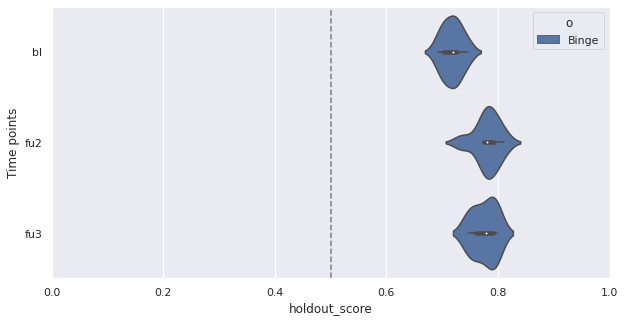

In [57]:
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.violinplot(x="holdout_score", y="path_type", hue="o",
            data=best_results_plot)
ax.set_xlim(0.0, 1.0)
ax.set_ylabel("Time points")
ax.axvline(0.5, label="chance", c='gray', ls='--', lw=1.5)

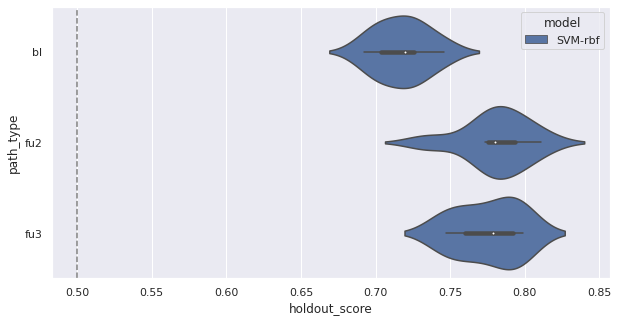

In [58]:
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.violinplot(x="holdout_score", y="path_type", hue="model",
            data=best_results_plot)
ax.axvline(0.5, label="chance", c='gray', ls='--', lw=1.5)

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.boxplot(y="holdout_roc_auc", hue="o", x="path_type",
            data=best_results, dodge=0.4)
ax.axhline(0.5, label="chance", c='gray', ls='--', lw=1.5)